In [4]:
import cv2 # computer vision
import numpy as np
import pandas as pd
import os # files 
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

In [9]:
# extraction_path = r"D:\HARenv\human detection and people count\extraction_frames"
extraction_path=r"D:\HARenv\human detection and people count\frames_HAR"

In [19]:
# Path to the video file
# video_path = r"D:\HARenv\multiPeopleHAR.mp4"
# video_path=r"D:\HARenv\HAR_OFFICE.mp4"
video_path=r"D:\HARenv\human detection and people count/harr.mp4"
# video_path=r"D:\HARenv\Dataset\sitting\sitting5.mp4"
# Open the video file
cap = cv2.VideoCapture(video_path)

# Get the frames per second (fps) of the video
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define the directory where frames will be saved
# extraction_path = r"D:\HARenv\human detection and people count\extraction_frames"
extraction_path=r"D:\HARenv\human detection and people count\frames_HAR"
# Initialize frame counter
frame_counter = 1

# Loop through the video frames
while True:
    ret, frame = cap.read()

    if not ret:
        break
    
    # Save the frame with a filename like "frame1.jpg" in the specified directory
    frame_filename = os.path.join(extraction_path, f'frame{frame_counter}.jpg')
    cv2.imwrite(frame_filename, frame)
    
    frame_counter += 1

# Release the video capture object6
cap.release()

print(f"The frames per second (fps) of the video is: {fps}")

The frames per second (fps) of the video is: 30


In [21]:
print(frame_counter)

8121


In [20]:
fps

30

In [33]:
#Duration is
duration=frame_counter/fps
total_time = "{:02}:{:02}:{:02}".format(int(duration // 3600), int((duration // 60) % 60), int(duration % 60))
print(total_time)

00:04:30


# (i) Object Detection and Bounding Boxes

# (ii) Counting People

# (iii) Screen Time Calculation


In [5]:
# yolov3 have single output layer for probability distribution and box predictions.
net = cv2.dnn.readNet('yolov4.weights', 'yolov4.cfg')
# weights - neural network parameters like bias,propagation etcc.
# cfg - configuration , architecture

In [6]:
# extraction_path=r"D:\HARenv\human detection and people count\extraction_frames"
extraction_path=r"D:\HARenv\human detection and people count\frames_HAR"

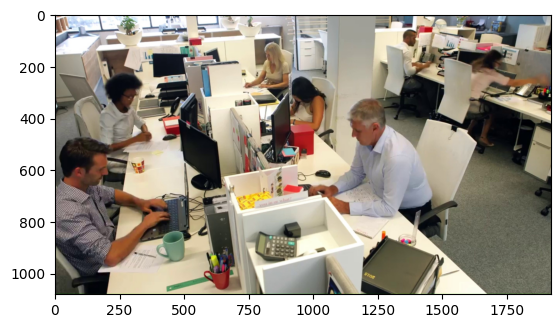

In [7]:
# img = plt.imread(r"D:\HARenv\human detection and people count\extraction_frames\frame20.jpg")   # reading image using its name
# plt.imshow(img)
img = plt.imread(r"D:\HARenv\human detection and people count\frames_HAR\frame20.jpg")   # reading image using its name
plt.imshow(img)

In [8]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")

# Human detection

In [9]:
# print(len(printed_person_ids))

# Counting people

In [ ]:
print(len(printed_person_ids))

# Calculate screen time of each person

In [ ]:
# WORST QUALITY
# from pytube import YouTube as yt
# video_link = "https://www.youtube.com/watch?v=9h2bKsJ7j_c"
# vid = yt(video_link)
# stream = vid.streams.first()
# stream.download()

In [ ]:
# df=pd.DataFrame(data)
# df

In [ ]:
# # csv_file = 'data1.csv'

# # # Save the DataFrame to a CSV file
# # df.to_csv(csv_file, index=False)

# data = pd.read_csv('data1.csv')

In [ ]:
# first_person = len(data[data['Person ID'] == 1])

# # Count rows where Class is 'Both in the frame'
# p2 = len(data[data['Person ID'] == 2])
# p3 = len(data[data['Person ID'] == 3])
# p4 = len(data[data['Person ID'] == 4])
# p5 = len(data[data['Person ID'] == 5])
# p6 = len(data[data['Person ID'] == 6])
# p7 = len(data[data['Person ID'] == 7])
# p8 = len(data[data['Person ID'] == 8])


# print(f"Count of 'person 1': {first_person} frames ")
# print(f"Count of 'person 2': {p2} frames" )
# print(f"Count of 'person 3': {p3} frames" )
# print(f"Count of 'person 4': {p4} frames" )
# print(f"Count of 'person 5': {p5} frames" )
# print(f"Count of 'person 6': {p6} frames" )
# print(f"Count of 'person 7': {p7} frames" )
# print(f"Count of 'person 8': {p8} frames" )

In [ ]:
# first_person/fps

Activity recognition

In [ ]:
# from tensorflow.keras.models import load_model
# model = load_model("D:\\HARenv\\HAR_officeActivity")
# # model = load_model(r"D:\HARenv\best_model.h5")

In [ ]:
# model.summary()

In [ ]:
# # model = load_model("D:\\HARenv\\HAR_officeActivity")
# model_2 = load_model(r"D:\HARenv\best_model.h5")

In [ ]:
# model_2.summary()

In [ ]:
# from tensorflow.keras.models import load_model

# activity_class_names = ['sitting', 'walking', 'sitting', 'standing', 'typing', 'mobile', 'writing']
# # activity_classes = ['drink', 'mobile', 'sitting', 'standing', 'typing', 'walking', 'writing']

# current_person_id = 0
# printed_person_ids = set()  # to keep track of already printed persons, set is used because of uniqueness
# class_ids = []  # 0 for people in the model
# data = []  # details of detected persons and their frames

# # Load your trained activity recognition model
# model = load_model("D:\\HARenv\\HAR_officeActivity")
# activity_recognition_model = model

# for i in range(1, frame_counter):
#     if i % 10 == 0:
#         frame_path = extraction_path + "\\frame%d.jpg" % i
#         image = cv2.imread(frame_path)
#         height, width = image.shape[:2]

#         # Preprocess the frames for YOLOv3
#         blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
#         # A pixel with a value of 0 is completely dark (black), while a pixel with a value of 255 is completely bright (white)
#    # 0.00392: This is a scaling factor. It's used to scale pixel values ( adjusting pixel values in a image). In YOLOv3, 
#    # images are usually preprocessed by dividing pixel values by 255.0, but this factor helps fine-tune the scaling and normalization
#    # open cv loads BGR so swapRB=True
#         net.setInput(blob) # sets input for the network

#         # Get output
#         outs = net.forward(net.getUnconnectedOutLayersNames())
#         # performs forward pass and gets the output.
#     # outs =    [x1, y1, width1, height1, confidence1, class_id1]... for all layers 
#     # outs - output layer

#         # Thresholds
#         conf_threshold = 0.9  # Increase confidence threshold
#         nms_threshold = 0.3

#         confidences = []
#         boxes = []

#         # Detection process
#         for out in outs:  # iterate each output layer
#             for detection in out: # iterate each detected object in that output layer
#                 scores = detection[5:]# scores contains the confidence scores for different classes
#                 class_id = np.argmax(scores) # class_id with the highest confidence
#                 confidence = scores[class_id]  # confidence score for class_id which may person,or object, person's class=0

#                 if confidence > conf_threshold and class_id == 0:# checks confidence > threshold class_id = 0 means people
#                     center_x = int(detection[0] * width)# horizontal center Calculates the x-coordinate of the center of the bounding box in pixels.
#                     center_y = int(detection[1] * height)#  vertical center Calculates the y-coordinate of the center of the bounding box in pixels.
#                     w = int(detection[2] * width)# width
#                     h = int(detection[3] * height)# height
#                     x = int(center_x - w / 2)# x-coordinate top left corner of bounding box
#                     y = int(center_y - h / 2)# y-coordinate top left corner of bounding box

#                     class_ids.append(class_id)
#                     confidences.append(float(confidence))
#                     boxes.append([x, y, w, h])
#                 # class_ids (the class ID, which is 0 for people), confidences (the confidence score),
#                 # and boxes (the coordinates and dimensions of the bounding box). 
#                 # This data can be used for further processing or visualization of the detected people


#         # Apply Non-Maximum Suppression (NMS)
#         indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

#         current_person_id = 0

#         for index in indices:
#             x, y, w, h = boxes[index]
#             color = (0, 255, 0)  # Green color

#             # Crop the ROI (Region of Interest) based on the bounding box
#             roi = image[y:y + h, x:x + w]

#             current_person_id += 1  # Tracking id

#             try:
#                 # Resize the ROI
#                 roi = cv2.resize(roi, (64, 64))
#                 roi = roi / 255.0  # Normalize to [0, 1]
#             except cv2.error as e:
#                 # Handle the error (empty image) here
#                 print(f"Error resizing ROI: {e}")
#                 continue

#             # Make a prediction using your activity recognition model
#             activity_predictions = activity_recognition_model.predict(np.expand_dims(roi, axis=0))

#             # Get the predicted activity class with the highest probability
#             predicted_activity_class = np.argmax(activity_predictions)

#             # Reduce boundary box thickness and text size
#             box_thickness = 1  # Decrease box thickness
#             text_scale = 0.5  # Decrease text size

#             # Draw the bounding box
#             cv2.rectangle(image, (x, y), (x + w, y + h), color, box_thickness)

#             # Define text settings
#             activity_class = activity_class_names[predicted_activity_class]  # Get the activity class
#             text = f"Person {current_person_id}, Activity: {activity_class}"

#             font = cv2.FONT_HERSHEY_SIMPLEX
#             font_color = (0, 0, 255)  # Red color

#             # Get the size of the text
#             (text_width, text_height), _ = cv2.getTextSize(text, font, text_scale, box_thickness)

#             # Calculate the position for the text to be centered in the bounding box
#             text_x = x + (w - text_width) // 2
#             text_y = y - 5  # Slightly above the top of the bounding box

#             # Display the text with the specified settings
#             cv2.putText(image, text, (text_x, text_y), font, text_scale, font_color, box_thickness)

#             # Append the data as a dictionary
#             data.append({
#                 "Frame Name": f"frame{i}.jpg",
#                 "Person ID": current_person_id,
#                 "Predicted Activity Class": activity_class,  # Include the activity class in the data
#             })

#         # Display the frame with bounding boxes
#         resized_image = cv2.resize(image, (800, 600))
#         cv2.imshow("Bounding box", resized_image)

#         key = cv2.waitKey(100)
#         if key == ord('q'):
#             break
            
# cv2.destroyAllWindows()

In [ ]:
# model = load_model("D:\\HARenv\\HAR_officeActivity")
# # model_2 = load_model(r"D:\HARenv\best_model.h5")

In [ ]:
# activity_class_names = ['sitting', 'walking', 'sitting', 'standing', 'typing', 'mobile', 'writing']
# # activity_classes = ['drink', 'mobile', 'sitting', 'standing', 'typing', 'walking', 'writing']

# current_person_id = 0
# printed_person_ids = set()  # to keep track of already printed persons, set is used because of uniqueness
# class_ids = []  # 0 for people in the model
# data = []  # details of detected persons and their frames

# # Load your trained activity recognition model
# model = load_model("D:\\HARenv\\HAR_officeActivity")
# activity_recognition_model = model

# for i in range(1, frame_counter):
#     if i % 10 == 0:
#         frame_path = extraction_path + "\\frame%d.jpg" % i
#         image = cv2.imread(frame_path)
#         height, width = image.shape[:2]

#         # Preprocess the frames for YOLOv3
#         blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
#         net.setInput(blob)

#         # Get output
#         outs = net.forward(net.getUnconnectedOutLayersNames())

#         # Thresholds
#         conf_threshold = 0.9  # Increase confidence threshold
#         nms_threshold = 0.3

#         confidences = []
#         boxes = []

#         # Detection process
#         for out in outs:
#             for detection in out:
#                 scores = detection[5:]
#                 class_id = np.argmax(scores)
#                 confidence = scores[class_id]

#                 if confidence > conf_threshold and class_id == 0:
#                     center_x = int(detection[0] * width)
#                     center_y = int(detection[1] * height)
#                     w = int(detection[2] * width)
#                     h = int(detection[3] * height)
#                     x = int(center_x - w / 2)
#                     y = int(center_y - h / 2)

#                     class_ids.append(class_id)
#                     confidences.append(float(confidence))
#                     boxes.append([x, y, w, h])

#         # Apply Non-Maximum Suppression (NMS)
#         indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

#         current_person_id = 0

#         for index in indices:
#             x, y, w, h = boxes[index]
#             color = (0, 255, 0)  # Green color

#             # Crop the ROI (Region of Interest) based on the bounding box
#             roi = image[y:y + h, x:x + w]

#             current_person_id += 1  # Tracking id

#             try:
#                 # Resize the ROI
#                 roi = cv2.resize(roi, (64, 64))
#                 roi = roi / 255.0  # Normalize to [0, 1]
#             except cv2.error as e:
#                 # Handle the error (empty image) here
#                 print(f"Error resizing ROI: {e}")
#                 continue

#             # Make a prediction using your activity recognition model
#             activity_predictions = activity_recognition_model.predict(np.expand_dims(roi, axis=0))

#             # Get the predicted activity class with the highest probability
#             predicted_activity_class = np.argmax(activity_predictions)

#             # Reduce boundary box thickness and text size
#             box_thickness = 1  # Decrease box thickness
#             text_scale = 0.5  # Decrease text size

#             # Draw the bounding box
#             cv2.rectangle(image, (x, y), (x + w, y + h), color, box_thickness)

#             # Define text settings
#             activity_class = activity_class_names[predicted_activity_class]  # Get the activity class
#             text = f"Person {current_person_id}, Activity: {activity_class}"

#             font = cv2.FONT_HERSHEY_SIMPLEX
#             font_color = (0, 0, 255)  # Red color

#             # Get the size of the text
#             (text_width, text_height), _ = cv2.getTextSize(text, font, text_scale, box_thickness)

#             # Calculate the position for the text to be centered in the bounding box
#             text_x = x + (w - text_width) // 2
#             text_y = y - 5  # Slightly above the top of the bounding box

#             # Display the text with the specified settings
#             cv2.putText(image, text, (text_x, text_y), font, text_scale, font_color, box_thickness)

#             # Append the data as a dictionary
#             data.append({
#                 "Frame Name": f"frame{i}.jpg",
#                 "Person ID": current_person_id,
#                 "Predicted Activity Class": activity_class,  # Include the activity class in the data
#             })

#         # Display the frame with bounding boxes
#         resized_image = cv2.resize(image, (800, 600))
#         cv2.imshow("Bounding box", resized_image)

#         key = cv2.waitKey(100)
#         if key == ord('q'):
#             break
            
# cv2.destroyAllWindows()

In [ ]:
# printed_person_ids = set()  # to keep track of already printed persons, set is used because of uniqueness
# class_ids = []  # 0 for people in the model
# data = []  # details of detected persons and their frames
# target_words = ["sitting", "walking", "standing", "writing"]
# for i in range(1, frame_counter):

#     frame_path = extraction_path + "\\frame%d.jpg" % i
#     image = cv2.imread(frame_path)
#     height, width = image.shape[:2]  # first 2 values in the image which are height and width

#     # Preprocess the frames for YOLOv3
#     blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
#     net.setInput(blob)  # sets input for the network

#     # Get output
#     outs = net.forward(net.getUnconnectedOutLayersNames())  # performs forward pass and gets the output.

#     # Thresholds
#     conf_threshold = 0.8
#     nms_threshold = 0

#     confidences = []
#     boxes = []

#     # Detection process
#     for out in outs:  # iterate each output layer
#         for detection in out:  # iterate each detected object in that output layer
#             scores = detection[5:]  # scores contain the confidence scores for different classes
#             class_id = np.argmax(scores)  # class_id with the highest confidence
#             confidence = scores[class_id]  # confidence score for class_id which may be person (person's class_id = 0)

#             if confidence > conf_threshold and class_id == 0:  # check if confidence > threshold and class_id is 0 (people)
#                 center_x = int(detection[0] * width)  # horizontal center
#                 center_y = int(detection[1] * height)  # vertical center
#                 w = int(detection[2] * width)  # width
#                 h = int(detection[3] * height)  # height
#                 x = int(center_x - w / 2)  # x-coordinate top left corner of bounding box
#                 y = int(center_y - h / 2)  # y-coordinate top left corner of bounding box

#                 class_ids.append(class_id)
#                 confidences.append(float(confidence))
#                 boxes.append([x, y, w, h])

#     # Apply Non-Maximum Suppression (NMS)
#     indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

#     # Draw bounding boxes without tracking
#     current_person_id = 0

#     for index in indices:
#         x, y, w, h = boxes[index]

#         # Crop the detected person from the frame
#         cropped_person = image[y:y + h, x:x + w]
#         current_person_id += 1
#         try:  
#             # Pass the cropped image to your caption generation model
#             raw_image = Image.fromarray(cv2.cvtColor(cropped_person, cv2.COLOR_BGR2RGB))
#         except cv2.error as e:
            
#             # Handle the error (empty image) here
#             print(f"Error resizing ROI: {e}")
#             continue
            
#         inputs = processor(raw_image, return_tensors="pt")
#         out = model.generate(**inputs)
#         caption = processor.decode(out[0], skip_special_tokens=True)
#         detected_action = None

#         # Search for target words in the generated caption
#         for word in target_words:
#             if word in caption:
#                 detected_action = word
#                 break  # Stop searching once a target word is found
        
#         # Print the detected action
#         if detected_action:
#             print(f"Frame {i} - Person {current_person_id} is {detected_action}")
#         else:
#             print(f"Frame {i} - Person {current_person_id} - No specific action detected")

#         # Print the caption for the person
#         # print(f"Frame {i} - Person {current_person_id} is {caption}")
        
#         # Display the cropped person with bounding box
#         cv2.imshow("Cropped Person", cropped_person)

#         key = cv2.waitKey(1)
    
#         if key == ord('q'):
#             break

# # Close all OpenCV windows
# cv2.destroyAllWindows()


In [11]:
current_person_id = 0

printed_person_ids = set()  # to keep track of already printed persons, set is used because of uniqueness
class_ids = []  # 0 for people in the model
data = []  # details of detected persons and their frames
frame_counter = 8200

target_words = ["sitting", "walking", "standing", "writing",'talking','mobile','typing','computer','chatting','leaning']
window_name = "Cropped Person"  # Define the window name

# Create a window and set its properties (you can adjust the size as needed)
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
cv2.resizeWindow(window_name, 400, 400)
# Load Yolo
classes = []
printed_person_ids = set()  # to keep track of already printed persons, set is used because of uniqueness
class_ids = []  # 0 for people in the model
data = []  # details of detected persons and their frames

with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

layer_names = net.getLayerNames()
output_layers = []
for i in net.getUnconnectedOutLayers():
    output_layers.append(layer_names[i - 1])

colors = np.random.uniform(0, 255, size=(len(classes), 3))

person_class_id = classes.index("person")


# Folder containing extracted frames
frame_folder = r"D:\HARenv\human detection and people count\frames_HAR"

# Get a list of frame file names in the folder
frame_files = [f for f in os.listdir(frame_folder) if os.path.isfile(os.path.join(frame_folder, f))]
frame_files.sort()  # Sort the frame files

for i in range(1, frame_counter,100):
    frame_path = extraction_path + "\\frame%d.jpg" % i
    image = cv2.imread(frame_path)
    height, width = image.shape[:2]  # first 2 values in the image which is height and width

    # Preprocess the frames for YOLOv3
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), swapRB=True, crop=False)
    # A pixel with a value of 0 is completely dark (black), while a pixel with a value of 255 is completely bright (white)
    # 0.00392: This is a scaling factor. It's used to scale pixel values ( adjusting pixel values in an image). In YOLOv3,
    # images are usually preprocessed by dividing pixel values by 255.0, but this factor helps fine-tune the scaling and normalization
    # open cv loads BGR so swapRB=True

    net.setInput(blob)  # sets input for the network

    # Get output
    outs = net.forward(net.getUnconnectedOutLayersNames())
    # outs =    [x1, y1, width1, height1, confidence1, class_id1]... for all layers
    # outs - output layer

    # Thresholds
    conf_threshold = 0
    nms_threshold = 0

    confidences = []
    boxes = []

    # Detection process
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence >= 0 and class_id == person_class_id:
                # Object detected as a person
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.1, 0.1)

    # indices hold the indices of the bounding boxes that represent distinct and confident detections
    current_person_id = 0

    # Draw bounding boxes without tracking
    for index in indices:
        x, y, w, h = boxes[index]
        color = (0, 255, 0)  # Green color
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 3)

        # Increment the person ID
        cropped_person = image[y:y + h, x:x + w]
        current_person_id += 1
        detected_action = None

        try:
            # Pass the cropped image to your caption generation model
            raw_image = cv2.resize(cropped_person, (800, 600))  # Resize the image for better display
            inputs = processor(Image.fromarray(cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)), return_tensors="pt")
            out = model.generate(**inputs)
            caption = processor.decode(out[0], skip_special_tokens=True)

            # # Search for target words in the generated caption
            # for word in target_words:
            #     if word in caption:
            #         detected_action = word
            #         break  # Stop searching once a target word is found

        except cv2.error as e:
            # Handle the error (empty image) here
            print(f"Error resizing ROI: {e}")

        # Store the frame, person ID, and detected action in the list
        # data.append([i, current_person_id, detected_action])
        data.append([i, current_person_id, caption])

        # Print the detected action
        # if detected_action:
        print(f"Frame {i} - Person {current_person_id} is {caption}")
        # else:
            # print(f"Frame {i} - Person {current_person_id} - No specific action detected")

        # Display the cropped person with bounding box
        try:
            cv2.imshow(window_name, raw_image)
        except cv2.error as e:
            # Handle the "size.width>0 && size.height>0" error with an exception
            print(f"Error displaying image: {e}")
    # Display the frame with bounding boxes
    resized_image = cv2.resize(image, (800, 600))
    cv2.imshow("Bounding box", resized_image)

    key = cv2.waitKey(1)
    
    if key == ord('q'):
        break

cv2.destroyAllWindows() 

Frame 1 - Person 1 is arafed man sitting at a desk with a laptop and a mouse
Error resizing ROI: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Frame 1 - Person 2 is arafed man sitting at a desk with a laptop and a mouse
Frame 1 - Person 3 is a close up of a person sitting at a desk with a laptop
Frame 1 - Person 4 is a close up of a woman writing on a piece of paper
Frame 1 - Person 5 is blond woman sitting at a desk with a laptop computer and a green frame
Frame 1 - Person 6 is a close up of a man sitting at a desk with a computer
Frame 1 - Person 7 is arafed woman sitting at a desk with a laptop and a phone
Frame 101 - Person 1 is arafed man sitting at a desk with a laptop and a mouse
Error resizing ROI: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Fram

In [12]:
data

[[1, 1, 'arafed man sitting at a desk with a laptop and a mouse'],
 [1, 2, 'arafed man sitting at a desk with a laptop and a mouse'],
 [1, 3, 'a close up of a person sitting at a desk with a laptop'],
 [1, 4, 'a close up of a woman writing on a piece of paper'],
 [1,
  5,
  'blond woman sitting at a desk with a laptop computer and a green frame'],
 [1, 6, 'a close up of a man sitting at a desk with a computer'],
 [1, 7, 'arafed woman sitting at a desk with a laptop and a phone'],
 [101, 1, 'arafed man sitting at a desk with a laptop and a mouse'],
 [101, 2, 'arafed man sitting at a desk with a laptop and a mouse'],
 [101, 3, 'there is a woman sitting at a desk with a laptop computer'],
 [101, 4, 'a close up of a woman writing on a piece of paper'],
 [101, 5, 'woman sitting at a desk with a laptop computer and a green screen'],
 [101, 6, 'a close up of a man sitting at a desk with a computer'],
 [101, 7, 'arafed woman sitting at a desk with a phone and a laptop'],
 [201, 1, 'arafed man 

In [13]:
df = pd.DataFrame(data)

In [14]:
df.to_csv('HAR_and_detection.csv', index=False)

In [5]:
data = pd.read_csv('HAR_and_detection.csv')

In [6]:
data

,0,1,2
0,1,1,arafed man sitting at a desk with a laptop and...
1,1,2,arafed man sitting at a desk with a laptop and...
2,1,3,a close up of a person sitting at a desk with ...
3,1,4,a close up of a woman writing on a piece of paper
4,1,5,blond woman sitting at a desk with a laptop co...
...,...,...,...
457,8101,1,there is a man sitting at a table writing on a...
458,8101,2,woman in white dress bending over to pick up a...
459,8101,3,a close up of a woman writing on a piece of paper
460,8101,4,there is a man sitting at a desk with a laptop


In [36]:
total_time

'00:04:30'

EACH PERSON ACTIVITY TIMELINE

In [41]:
# Initialize a dictionary to store the start and end frames for each person and action
person_action_frames = {}

# Loop through each row in the DataFrame
for index, row in data.iterrows():
    frame = row["0"]
    person_id = row["1"]
    detected_action = row["2"].lower()  # Convert to lowercase for case-insensitive matching

    # Initialize frame range for the current person if not already done
    if person_id not in person_action_frames:
        person_action_frames[person_id] = {action: [] for action in target_words}

    # Check if any of the target words/actions are present in the detected action
    for action in target_words:
        if action in detected_action:
            person_action_frames[person_id][action].append(frame)

# Print the results
for person_id, actions in person_action_frames.items():
    print(f"Person {person_id} activities:")
    for action, frames in actions.items():
        if frames:
            start_frame = min(frames)
            end_frame = max(frames)
            seconds=((end_frame-start_frame)/fps)/60
            print(f"{action} from frame {start_frame} to {end_frame} total minutes {seconds}")
    print()

Person 1 activities:
sitting from frame 1 to 8101 total minutes 4.5
writing from frame 3801 to 8101 total minutes 2.388888888888889
talking from frame 5801 to 5801 total minutes 0.0
computer from frame 201 to 7201 total minutes 3.888888888888889

Person 2 activities:
sitting from frame 1 to 8001 total minutes 4.444444444444445
writing from frame 501 to 6201 total minutes 3.1666666666666665
talking from frame 301 to 5801 total minutes 3.055555555555556
computer from frame 201 to 7201 total minutes 3.888888888888889
leaning from frame 5601 to 5601 total minutes 0.0

Person 3 activities:
sitting from frame 1 to 7801 total minutes 4.333333333333333
standing from frame 3801 to 4101 total minutes 0.16666666666666666
writing from frame 401 to 8101 total minutes 4.277777777777778
talking from frame 501 to 6001 total minutes 3.055555555555556
computer from frame 101 to 7501 total minutes 4.111111111111111
leaning from frame 5601 to 5601 total minutes 0.0

Person 4 activities:
sitting from frame